### Testing Bootstrapping against MCMC

In [1]:
# math, array manipulation, etc.
import numpy as np

# timing
from timeit import default_timer

import astropy.io.fits as fits
from astropy.table import Table                    # Table data structure
import astropy.units as u

# necessary utilities from scipy, astropy and photutils
from scipy.optimize import differential_evolution
from scipy.ndimage import maximum_filter, gaussian_filter
from astropy.modeling import functional_models
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma, SigmaClip
from photutils.background import Background2D, StdBackgroundRMS
from photutils.segmentation import deblend_sources, SegmentationImage, detect_sources

# plots
import matplotlib.pyplot as plt
import corner                       # giant triangle confusograms!

#%matplotlib inline

# MCMC sampling package
import emcee
from tqdm import tqdm

import os

import sys
print(sys.version)



Bad key text.latex.preview in file /Users/aidan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/aidan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/aidan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the de

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
sys.path.append('/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/')

from imfit_mcmc import LensPhoto, fwhm2sigma

from aidan_utils import plot_prettier, read_fits_image, get_fits_files

# only need to run once
plot_prettier()

In [3]:
jr_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/rband_dr2/no_cluster_scale/mask_works/fit_works/'
jg_path = '/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/gband_dr2/no_cluster_scale/mask_works/fit_works/'

files_r = get_fits_files(jr_path)
files_g = get_fits_files(jg_path)

index = 96

img_r = fits.open(files_r[index])[0].data
img_g = fits.open(files_g[index])[0].data

print(files_r[index])
print(files_g[index])

/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/rband_dr2/no_cluster_scale/mask_works/fit_works/DESJ233459.1960-640406.9600_r.fits
/Users/aidan/Desktop/sl_project/img_cutouts/sl_jacobs/gband_dr2/no_cluster_scale/mask_works/fit_works/DESJ233459.1960-640406.9600_g.fits


In [4]:
# begin by calling a quick fit

# then test bootstrapping using the example in the pyimfit documentation

# then run an MCMC call and compare posterior distributions using corner
# (change to imfit's likelihood calculation, see ## comments in infit_mcmc function)

fwhm_r = 0.95
fwhm_g = 1.11

std_psf_r = fwhm2sigma(fwhm_r)
std_psf_g = fwhm2sigma(fwhm_g)


In [5]:
photo = LensPhoto(img_r = img_r, img_g = img_g
                  , std_psf_r = std_psf_r, std_psf_g = std_psf_g
                  , desid = '1')

/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/imfit_mcmc.py:192: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/imfit_mcmc.py:192: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)


[[2.6010718 2.91288   2.6010718 ... 2.8530056 2.6010718 2.6010718]
 [2.6010718 3.1672952 2.6010718 ... 2.6010718 2.6010718 2.6010718]
 [2.6010718 2.7784188 2.6010718 ... 2.7672813 2.6010718 2.7225587]
 ...
 [2.6763031 3.048866  2.6010718 ... 2.6010718 2.6010718 2.6010718]
 [2.6444654 2.6010718 2.6010718 ... 2.6010718 2.6010718 2.6010718]
 [2.6385667 2.6010718 2.6010718 ... 2.6489158 2.6010718 2.6010718]]
[[1.7916338 1.816215  1.7916338 ... 1.7916338 1.7916338 1.7916338]
 [1.7916338 1.7916338 1.7916338 ... 2.1407485 1.7916338 1.7916338]
 [1.8176123 1.7916338 1.7916338 ... 1.8033943 2.1581006 1.7916338]
 ...
 [1.7916338 1.956612  1.7916338 ... 1.7916338 1.7916338 1.7916338]
 [2.0953872 1.7916338 1.8719454 ... 1.9874676 1.7916338 1.9632646]
 [1.7916338 1.7916338 1.7916338 ... 1.7916338 1.7916338 1.7933462]]


In [28]:
run, dist = photo.mcmc_run(nwalkers=20, steps=1500)

# this works better! now

100%|██████████| 1500/1500 [07:23<00:00,  3.38it/s]


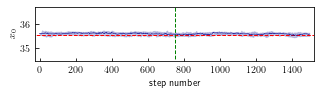

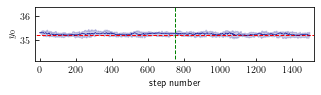

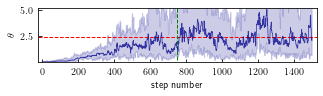

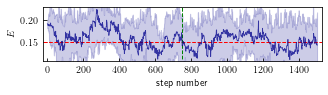

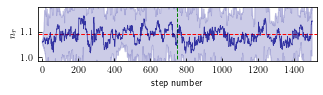

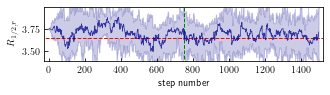

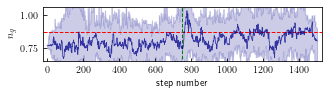

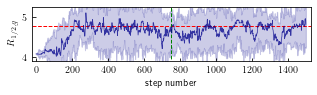

In [37]:
samples2 = run[500:, :, :].reshape(-1, 8)

photo.plot_trace()


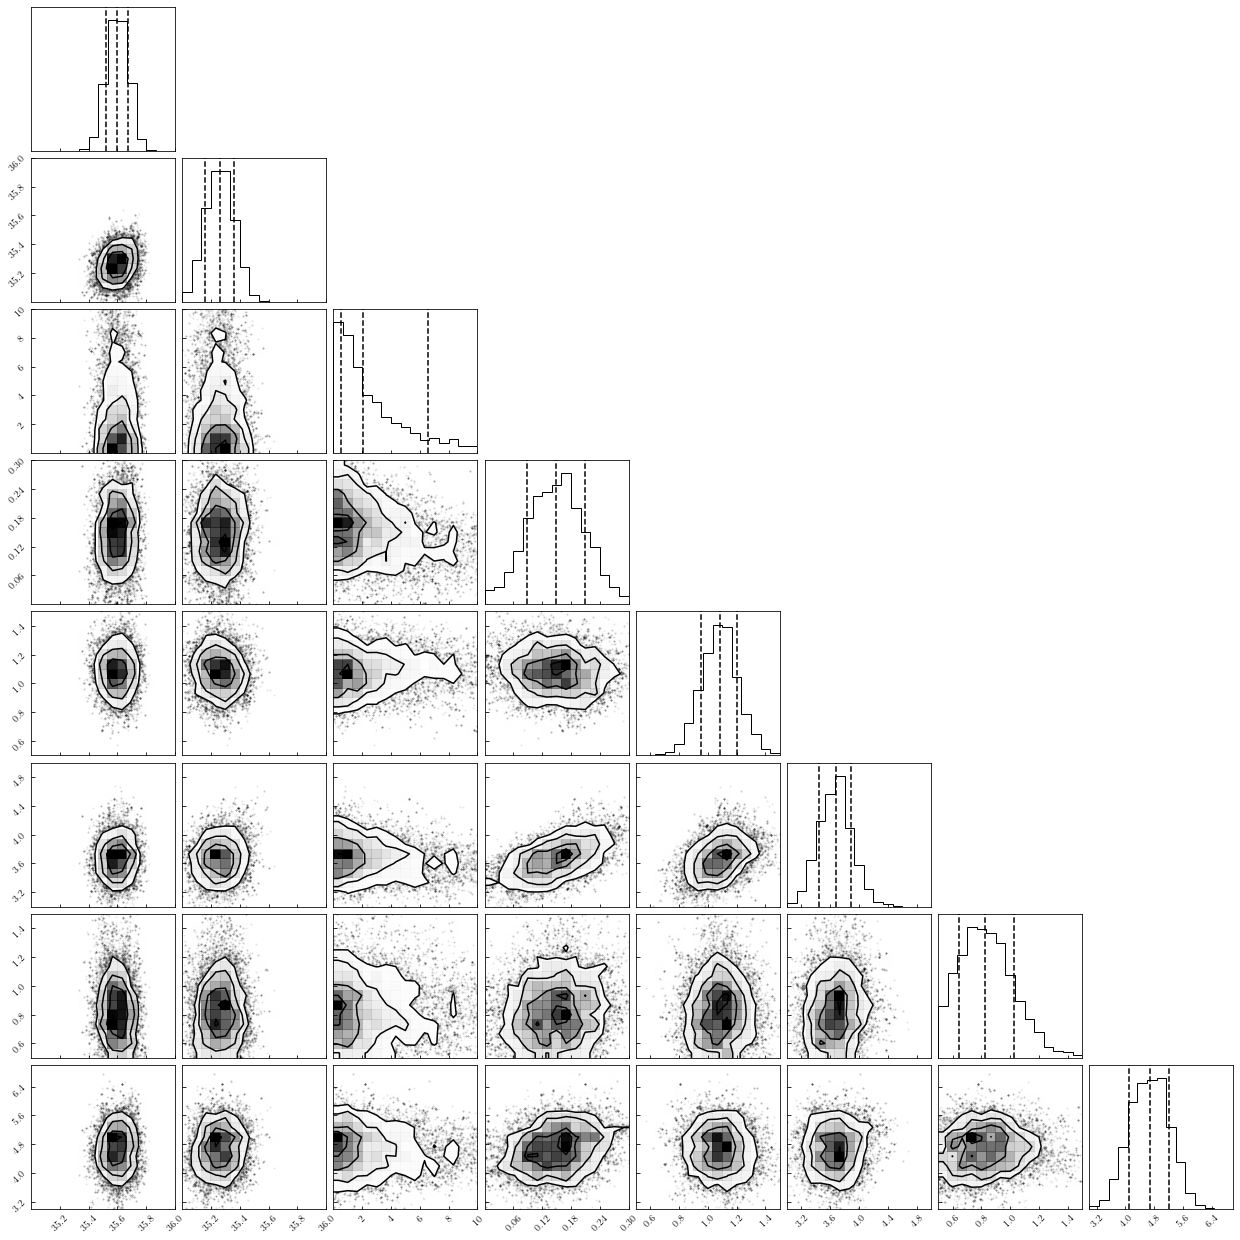

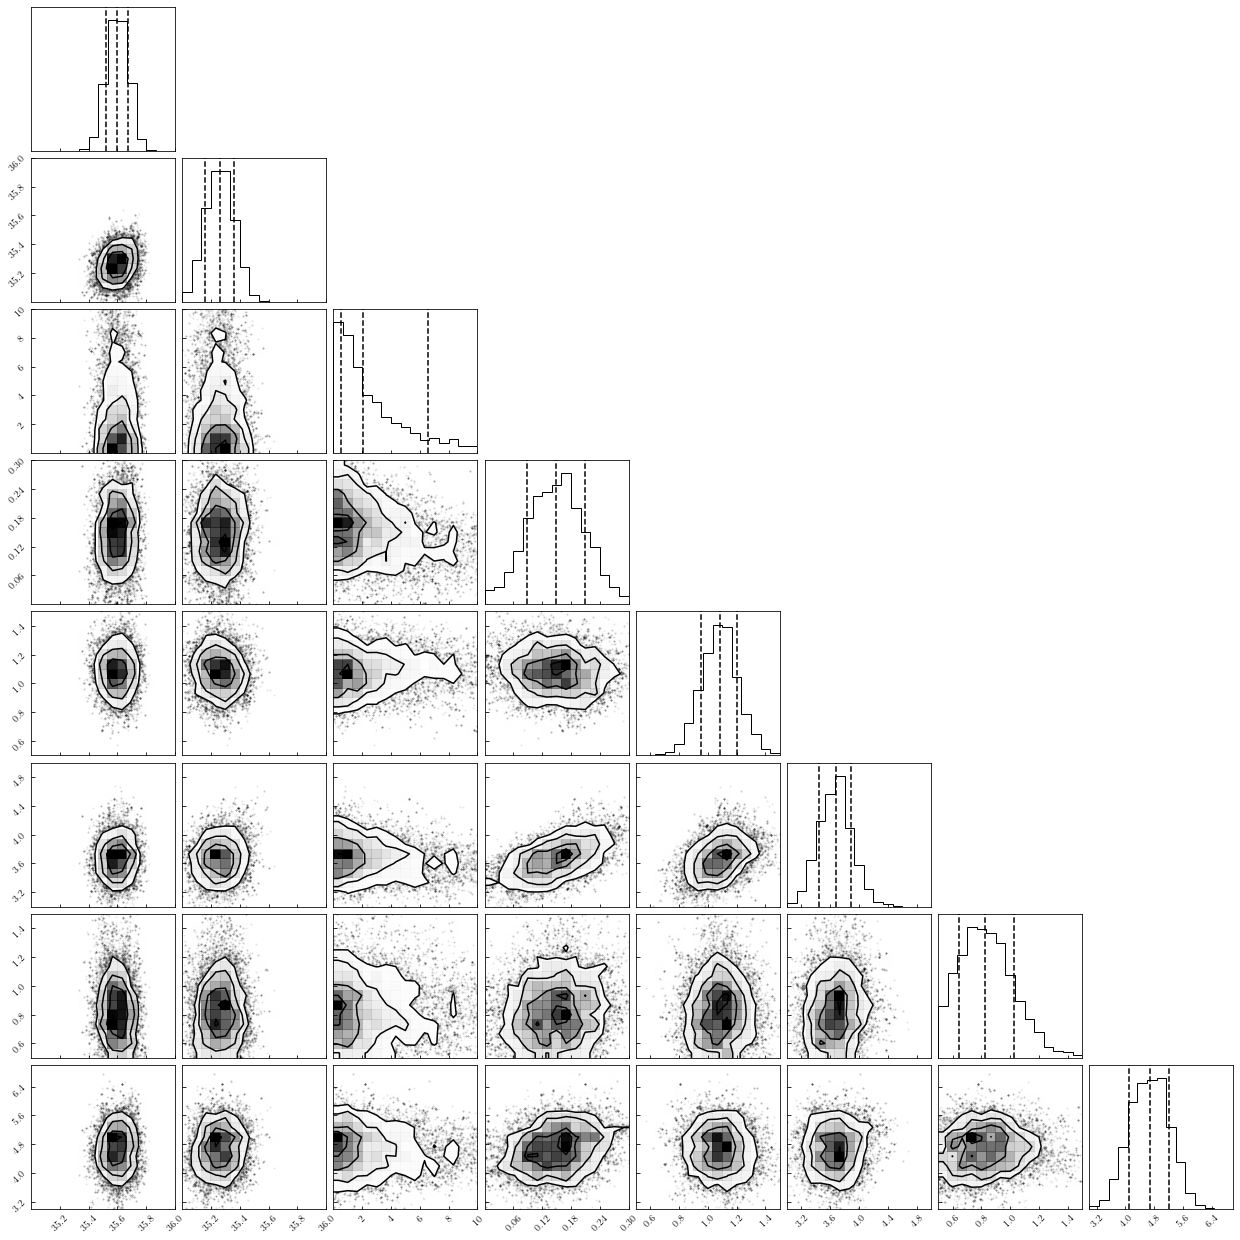

In [49]:
ranges = [(35, 36), (35, 36), (0, 10), (0, 0.3), (0.5, 1.5), (3, 5), (0.5, 1.5), (3,7)]

corner.corner(samples2, bins=15, quantiles=(0.16, 0.5, 0.84), range=ranges)

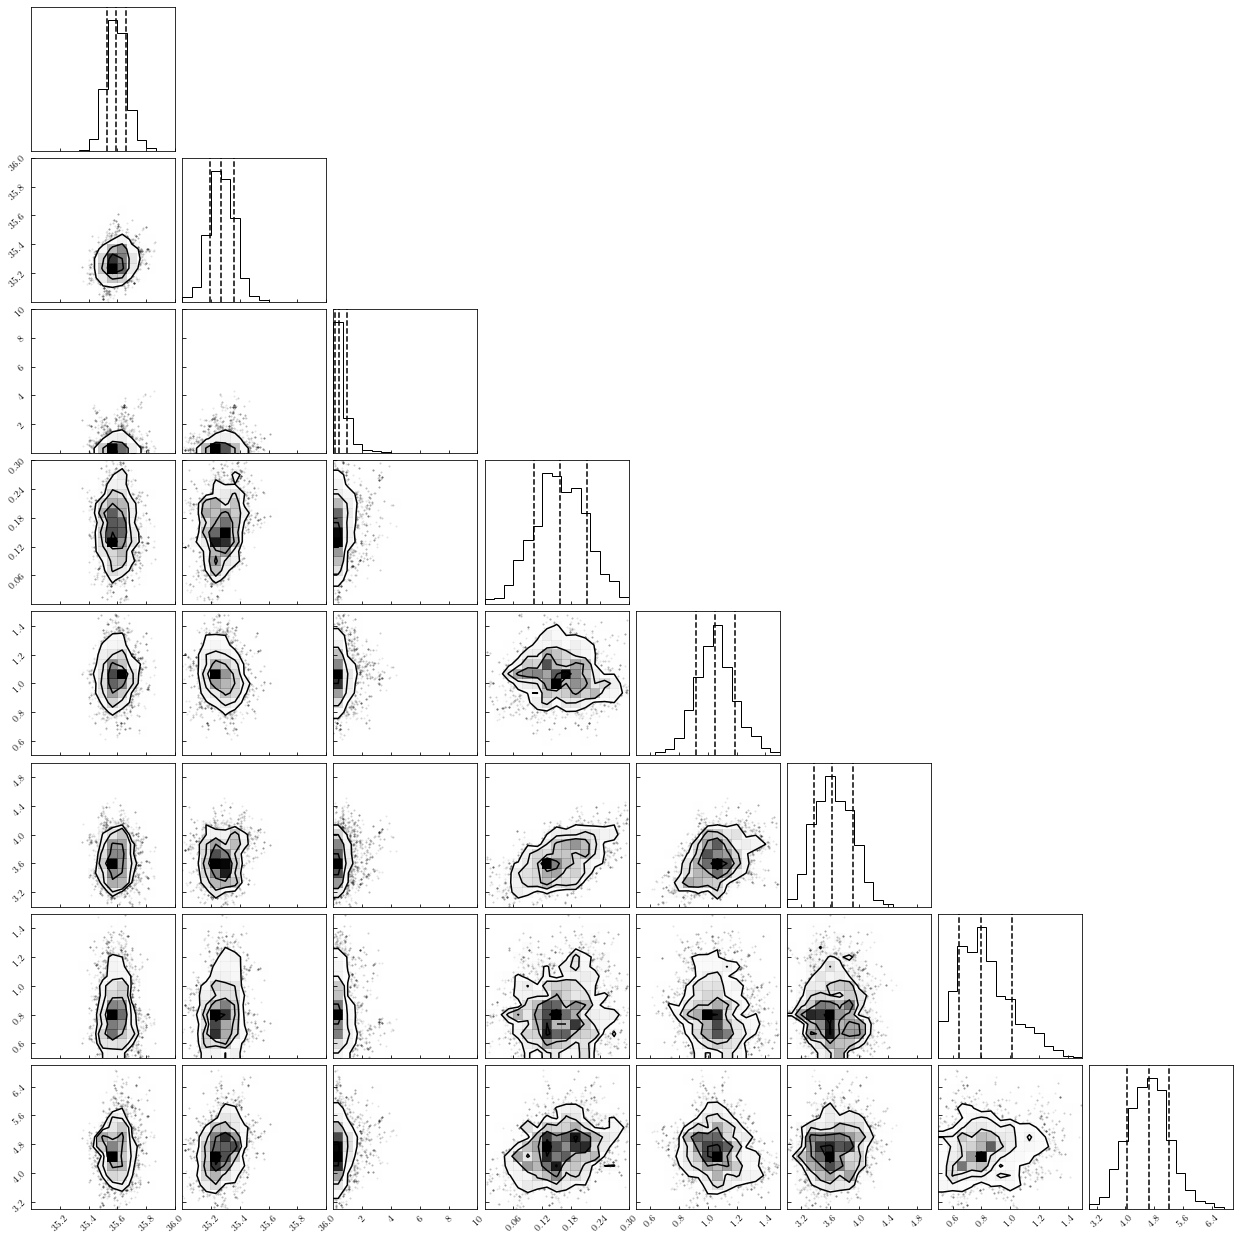

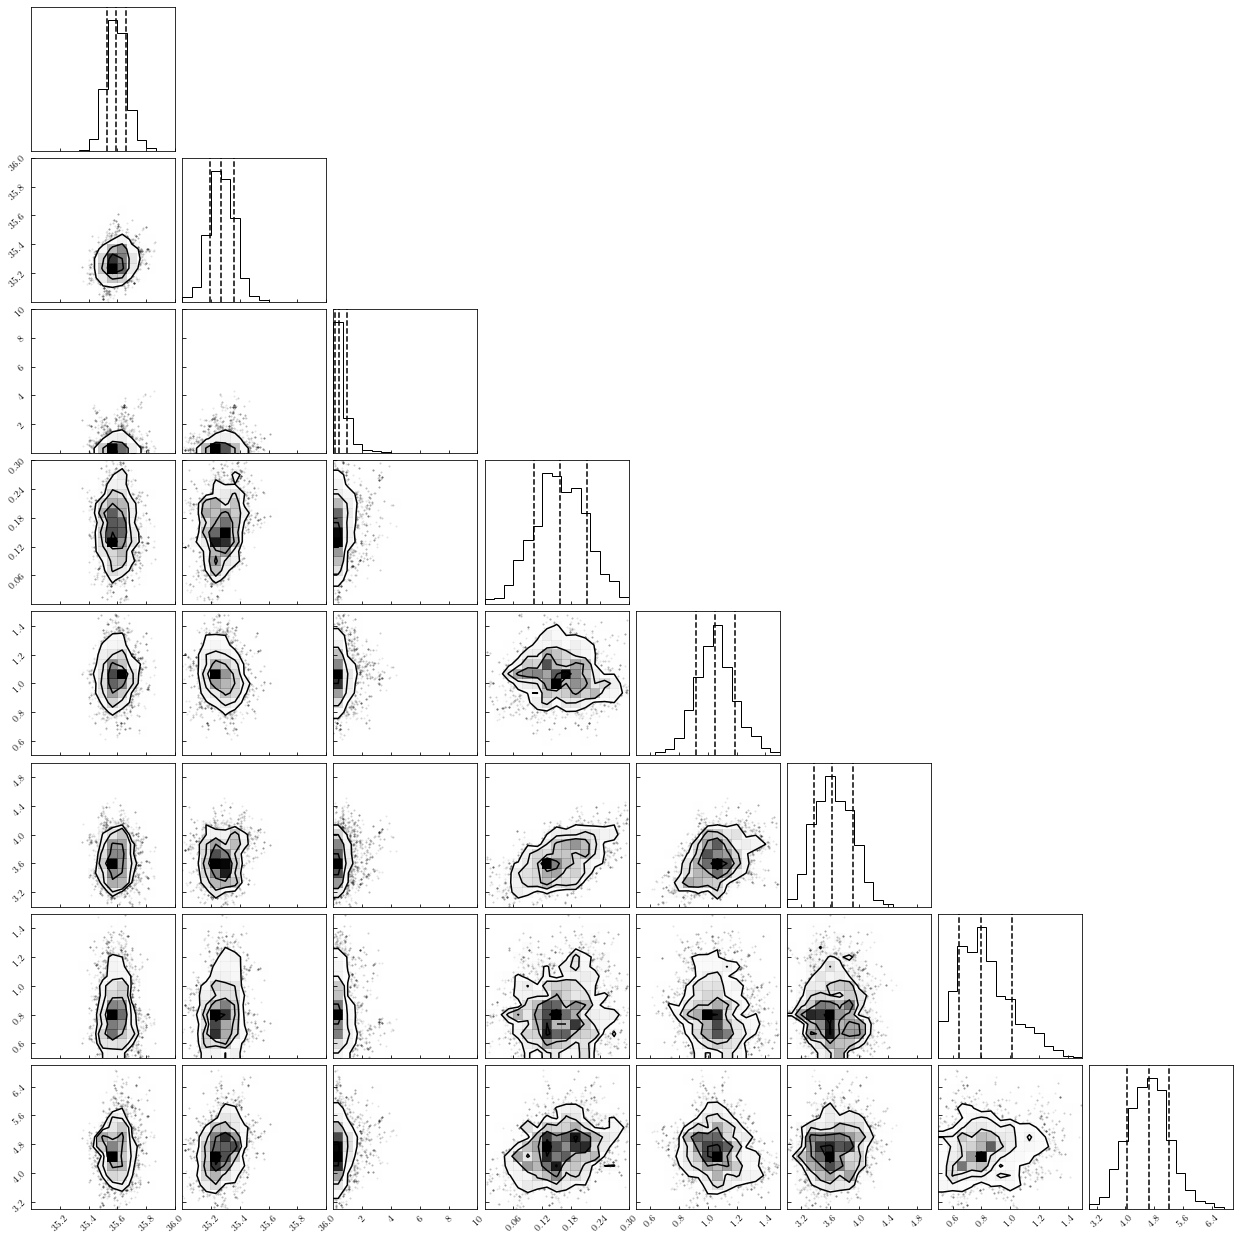

In [50]:
corner.corner(samples, bins=15, quantiles=(0.16, 0.5, 0.84), range=ranges)

In [6]:
bestfit_r, bestfit_g = photo.quick_fit()

# there's a problem over here with my kernel on gal-gal-sel 
# let's test step by step at some point, but for now I'll use the base environment

In [12]:
niter = 300
time = default_timer()
parameterNames, bootstrapResults_r = photo.imfit_r.runBootstrap(niter, getColumnNames=True)
print(time)

266.572817532


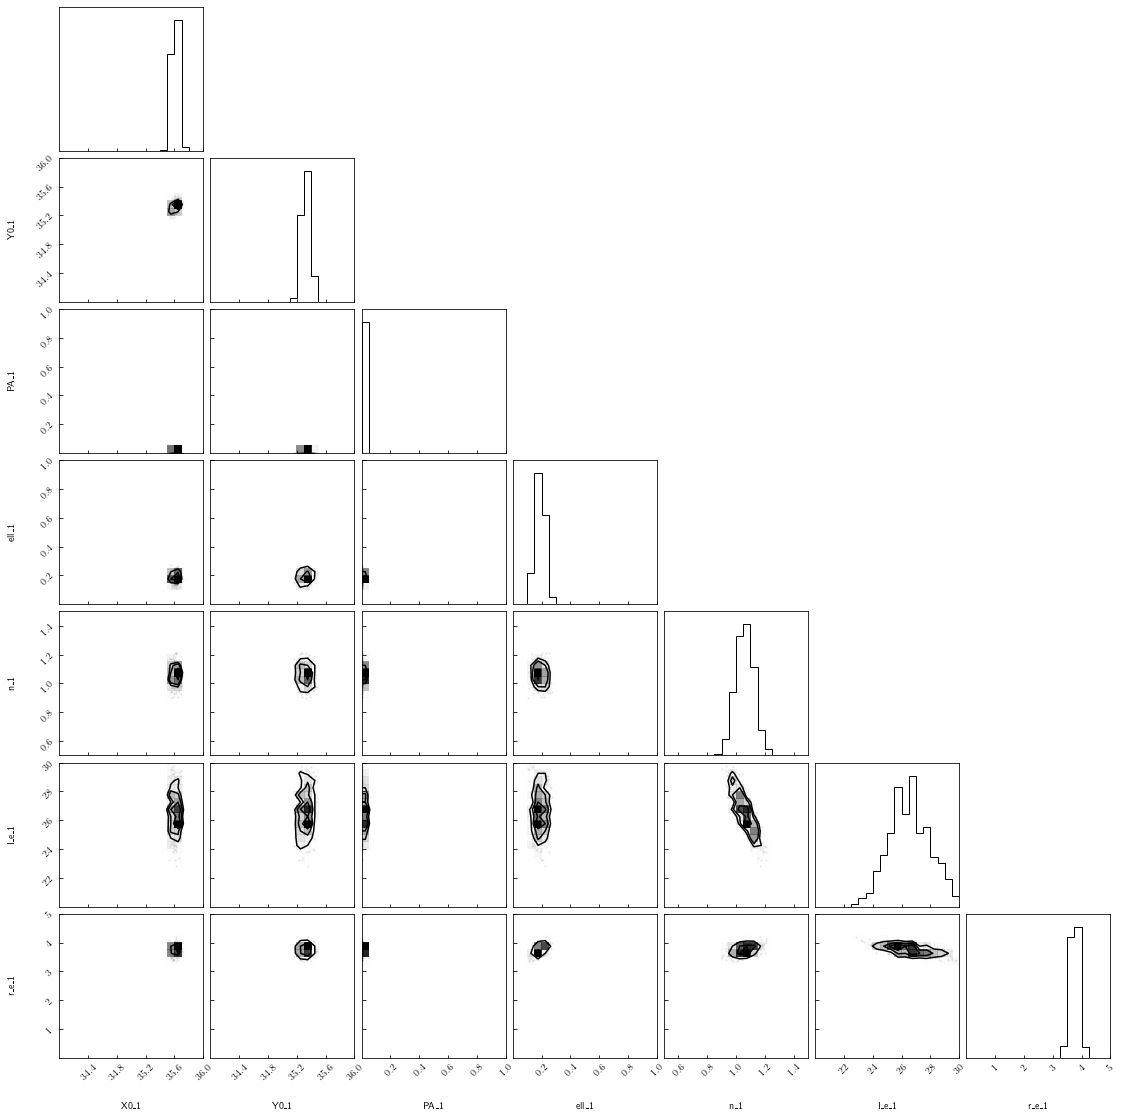

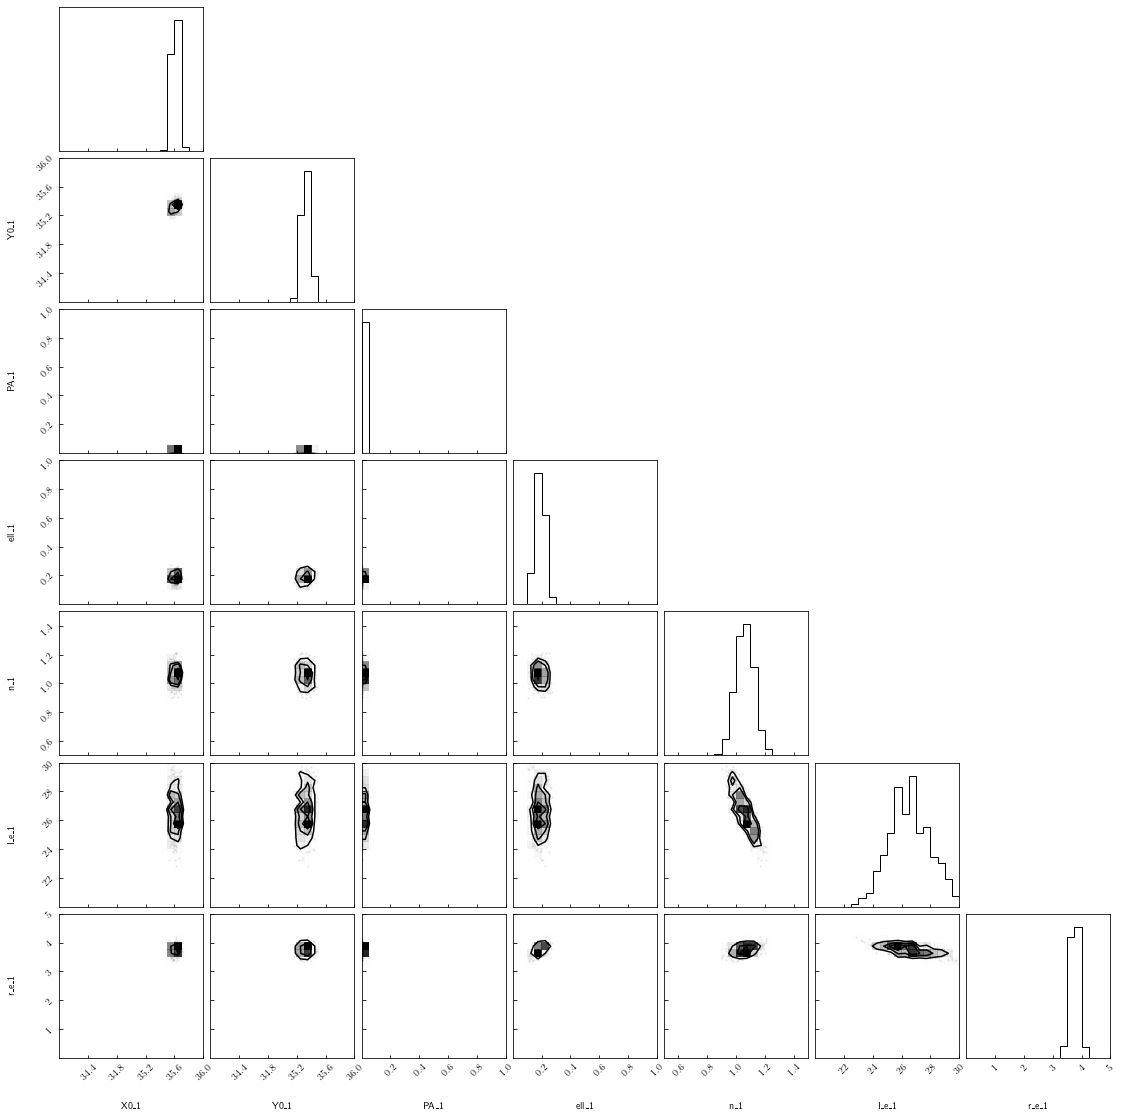

In [13]:
corner.corner(bootstrapResults_r, labels=parameterNames
              , range=[(34.,36.), (34.,36), (0,1), (0,1), (0.5, 1.5), (20, 30), (0, 5)])